In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import re

sns.set_theme()

In [2]:
def get_metrics(
        logs_to_evaluate,
        hist_stats_names=("policy_main_reward", "win_rate", "final_score_0", "final_score_1", "undesirable_action_0")
):
    for stage in logs_to_evaluate:
        logs_paths = stage["log_paths"]
        stage["data"] = {}
        for log_path in logs_paths:
            files = [os.path.join(log_path, f) for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f)) and f.startswith('result_iteration_')]
            files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

            hist_stats = defaultdict(list)
            for file in files:
                with open(file) as f:
                    d = json.load(f)
                    for hist_stat in hist_stats_names:
                        if hist_stat not in d["env_runners"]["hist_stats"]:
                            continue
                        hist_stats[hist_stat].append(np.array(d["env_runners"]["hist_stats"][hist_stat]))
                        hist_stats[hist_stat+"_mean"].append(np.mean(hist_stats[hist_stat][-1]))
                        hist_stats[hist_stat+"_min"].append(np.mean(hist_stats[hist_stat][-1]))
                        hist_stats[hist_stat+"_max"].append(np.mean(hist_stats[hist_stat][-1]))

            stage["data"][log_path] = hist_stats

In [3]:
# Add all paths to the experiments here
logs_to_evaluate = [
    {
        "title": "Different Action Reward Reductions and Decays",
        "log_paths": {
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_5_fixed_decay_0.95_ent_0.01_nn_[32]_against_other": "AR=5, Decay=0.95",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_5_fixed_decay_0.98_ent_0.01_nn_[32]_against_other": "AR=5, Decay=0.98",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_5_fixed_decay_0.995_ent_0.01_nn_[32]_against_other": "AR=5, Decay=0.995",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.95_ent_0.01_nn_[32]_against_other": "AR=1, Decay=0.95",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[32]_against_other": "AR=1, Decay=0.98",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.995_ent_0.01_nn_[32]_against_other": "AR=1, Decay=0.995",
        }
    },
    {
        "title": "Efficient One Hot vs. simple encoding and different NN sizes",
        "log_paths": {
            "logs/grid_search/obs_efficient_one_hot_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[16]_against_other": "EOH, 16 Neurons",
            "logs/grid_search/obs_efficient_one_hot_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[32]_against_other": "EOH, 32 Neurons",
            "logs/grid_search/obs_efficient_one_hot_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[64]_against_other": "EOH, 64 Neurons",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[16]_against_other": "Simple, 16 Neurons",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[32]_against_other": "Simple, 32 Neurons",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[64]_against_other": "Simple, 64 Neurons",
        }
    },
    {
        "title": "Efficient One Hot vs. simple encoding and different NN sizes",
        "log_paths": {
            "logs/grid_search/obs_efficient_one_hot_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[32, 32]_against_other": "EOH, [32, 32]",
            # "logs/grid_search/obs_efficient_one_hot_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[64, 64]_against_other": "EOH, [64, 64],
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[32, 32]_against_other": "Simple, [32, 32]",
            "logs/grid_search/obs_simple_indirect_False_vf_True_cr_0_ar_1_fixed_decay_0.98_ent_0.01_nn_[64, 64]_against_other": "Simple, [64, 64]",
        }
    }
]

get_metrics(logs_to_evaluate)
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
for stage in logs_to_evaluate:
    title, log_paths, data = stage["title"], stage["log_paths"], stage["data"]
    print("======================================================")
    print(title)
    print("======================================================\n")
    for log_path in log_paths:
        # find the ten consecutive iterations with the highest win rate
        win_rate = data[log_path]["win_rate_mean"]
        max_win_rate = 0
        max_win_rate_idx = 0
        for idx in range(len(win_rate) - 10):
            if np.mean(win_rate[idx:idx+10]) > max_win_rate:
                max_win_rate = np.mean(win_rate[idx:idx+10])
                max_win_rate_idx = idx
        mean_final_score = np.mean(data[log_path]["final_score_0_mean"][max_win_rate_idx:max_win_rate_idx+10])
        mean_win_rate = np.mean(data[log_path]["win_rate_mean"][max_win_rate_idx:max_win_rate_idx+10])
        undesirable_actions = np.mean(data[log_path]["undesirable_action_0_mean"][max_win_rate_idx:max_win_rate_idx+10])

        print(f"{log_paths[log_path]} - Final Score: {mean_final_score}")
        print(f"{log_paths[log_path]} - Win Rate: {mean_win_rate}")
        print(f"{log_paths[log_path]} - Undesirable Actions: {undesirable_actions}\n")

Different Action Reward Reductions and Decays

AR=5, Decay=0.95 - Final Score: 20.574
AR=5, Decay=0.95 - Win Rate: 0.53
AR=5, Decay=0.95 - Undesirable Actions: 17.171

AR=5, Decay=0.98 - Final Score: 21.798000000000002
AR=5, Decay=0.98 - Win Rate: 0.5149999999999999
AR=5, Decay=0.98 - Undesirable Actions: 17.266000000000002

AR=5, Decay=0.995 - Final Score: 21.610999999999997
AR=5, Decay=0.995 - Win Rate: 0.485
AR=5, Decay=0.995 - Undesirable Actions: 17.532000000000004

AR=1, Decay=0.95 - Final Score: 20.058999999999997
AR=1, Decay=0.95 - Win Rate: 0.558
AR=1, Decay=0.95 - Undesirable Actions: 17.240000000000002

AR=1, Decay=0.98 - Final Score: 20.403
AR=1, Decay=0.98 - Win Rate: 0.5509999999999999
AR=1, Decay=0.98 - Undesirable Actions: 17.473000000000003

AR=1, Decay=0.995 - Final Score: 21.303999999999995
AR=1, Decay=0.995 - Win Rate: 0.526
AR=1, Decay=0.995 - Undesirable Actions: 17.159

Efficient One Hot vs. simple encoding and different NN sizes

EOH, 16 Neurons - Final Score: 2

In [5]:
def plot_metric(logs_to_evaluate, metric, metric_name):
    for stage in logs_to_evaluate:
        title, log_paths, data = stage["title"], stage["log_paths"], stage["data"]
        for log_path in log_paths:
            sns.lineplot(data[log_path][metric], alpha=0.2)
        plt.gca().set_prop_cycle(None)
        for log_path in log_paths:
            sns.lineplot(np.convolve(data[log_path][metric], np.ones(10)/10, mode="valid"), label=log_paths[log_path], alpha=1)
        plt.title(f"{title} - {metric_name}")
        # show legend at the bottom below the whole figure
        plt.legend(loc='upper left', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

        plt.show()

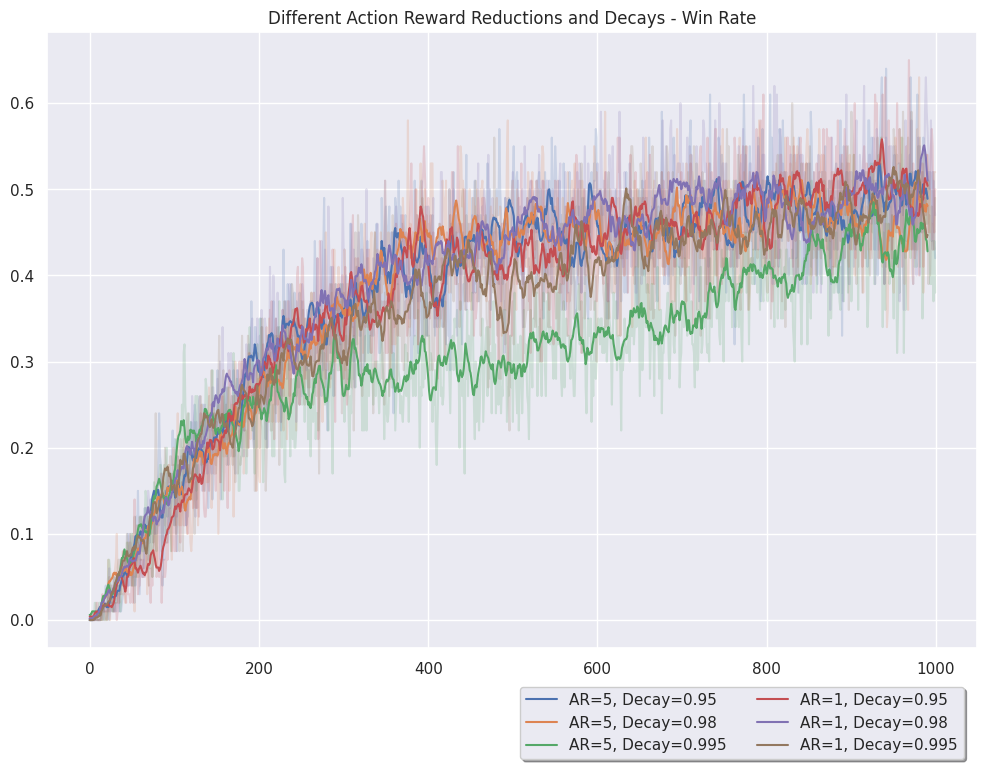

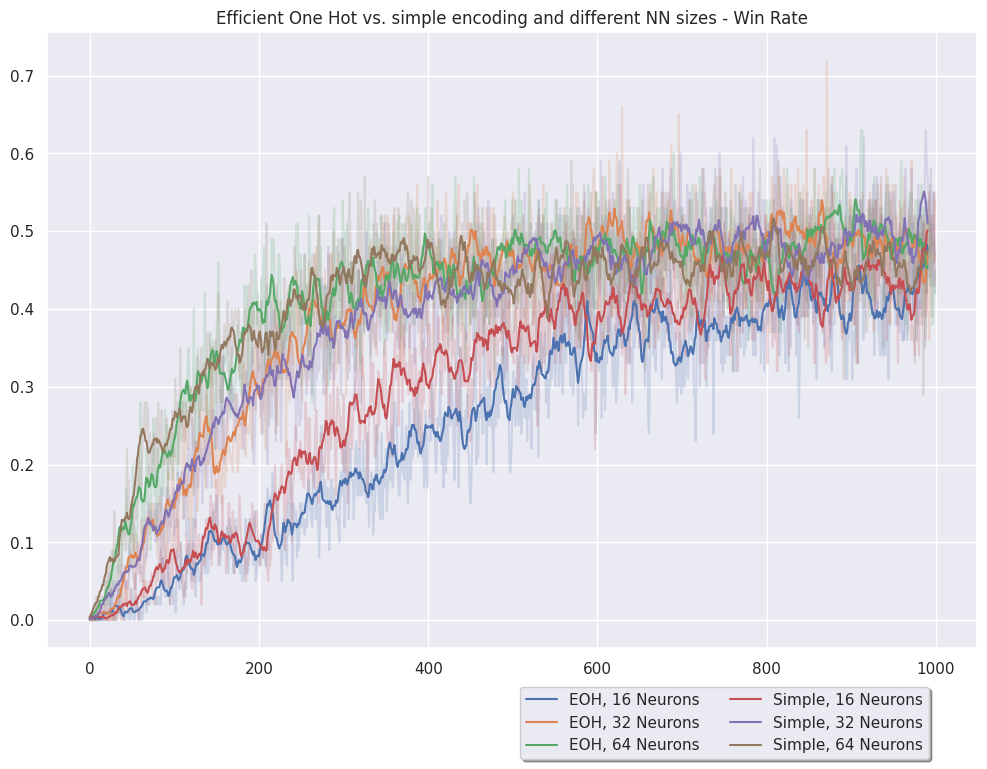

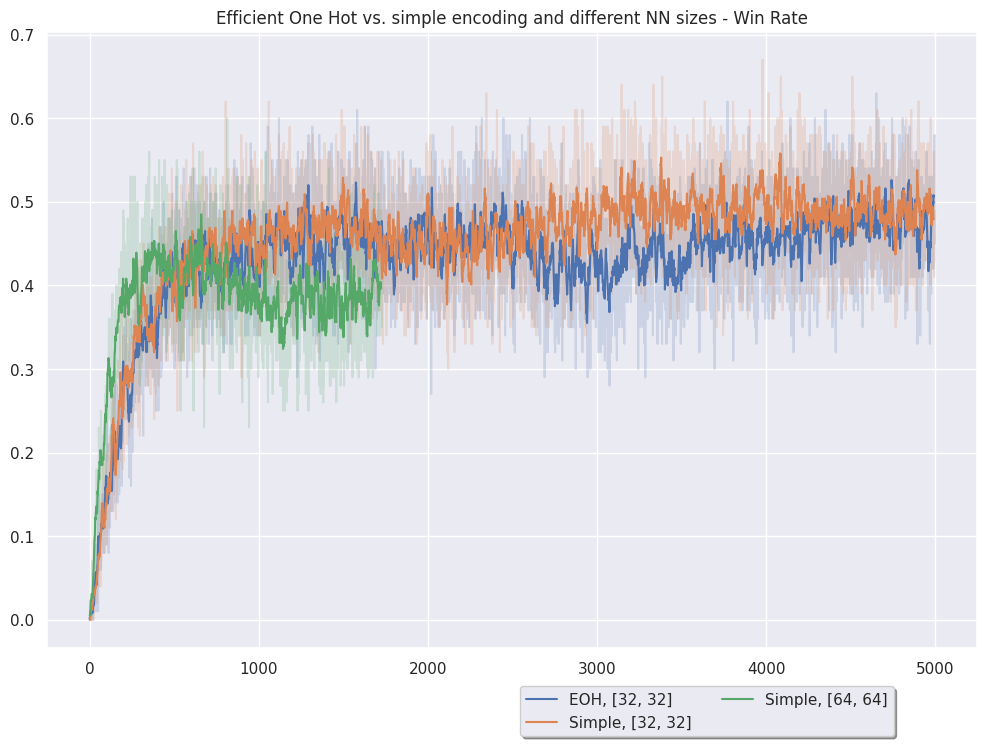

In [6]:
plot_metric(logs_to_evaluate, "win_rate_mean", "Win Rate")

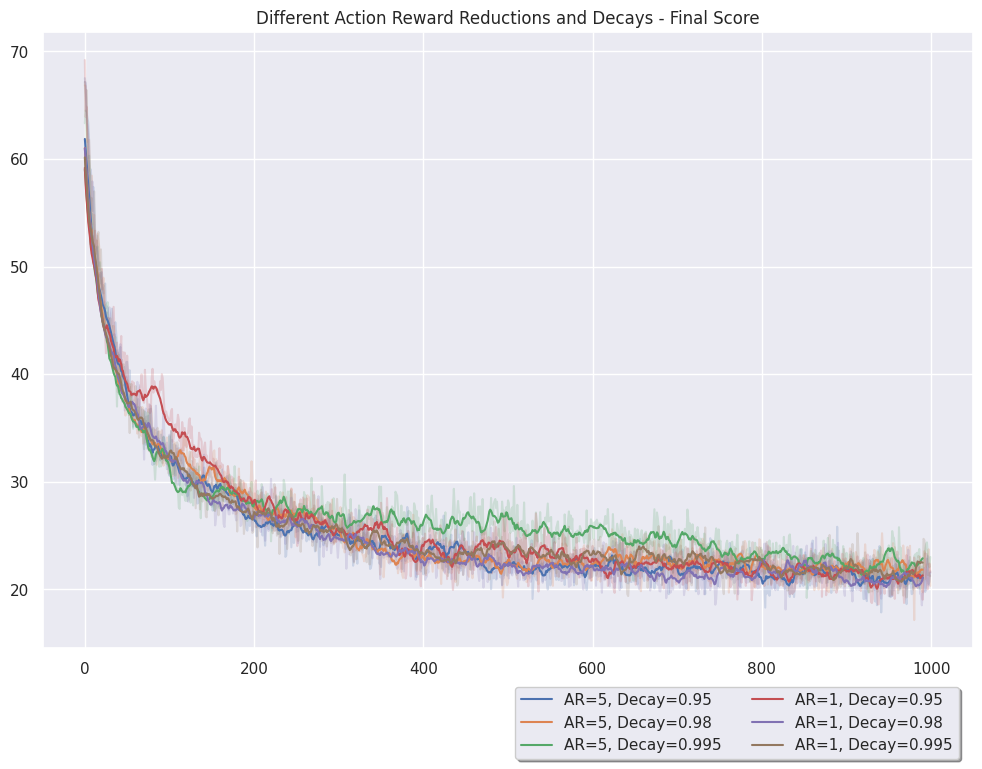

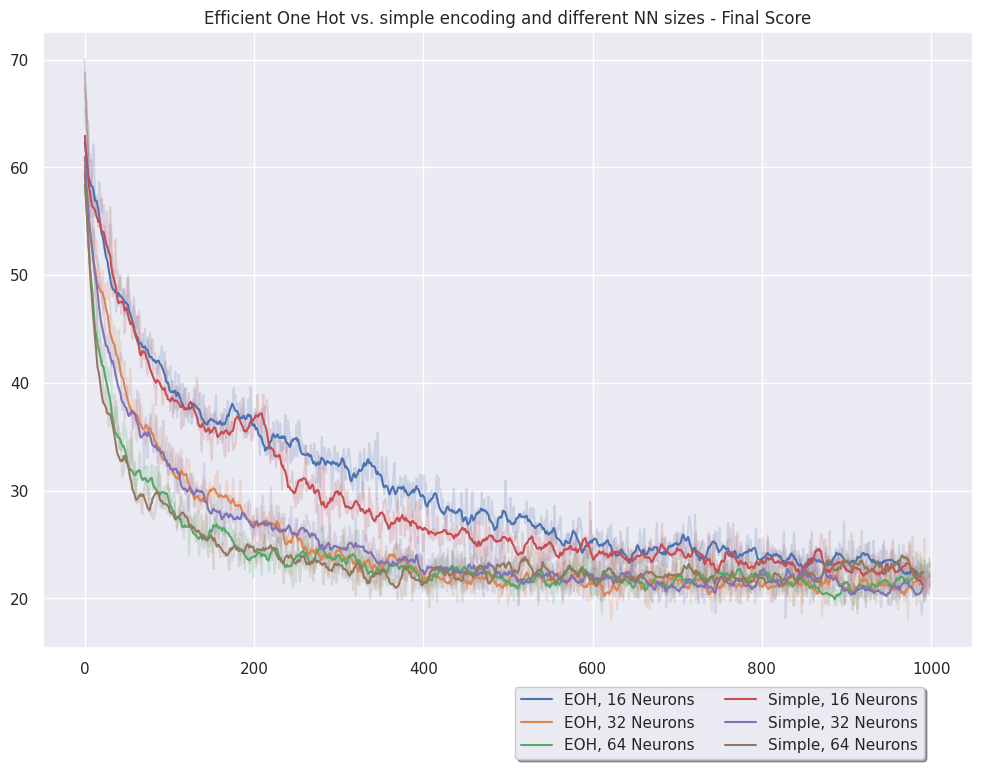

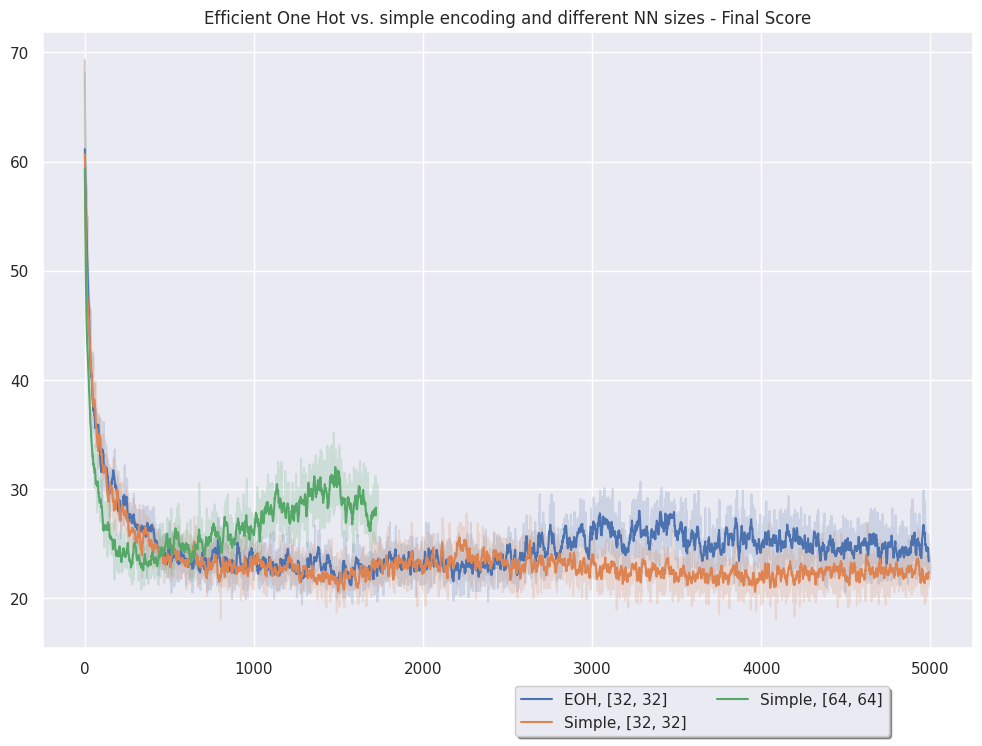

In [7]:
plot_metric(logs_to_evaluate, "final_score_0_mean", "Final Score")

In [ ]:
plot_metric(logs_to_evaluate, "policy_main_reward_mean", "Mean Reward")

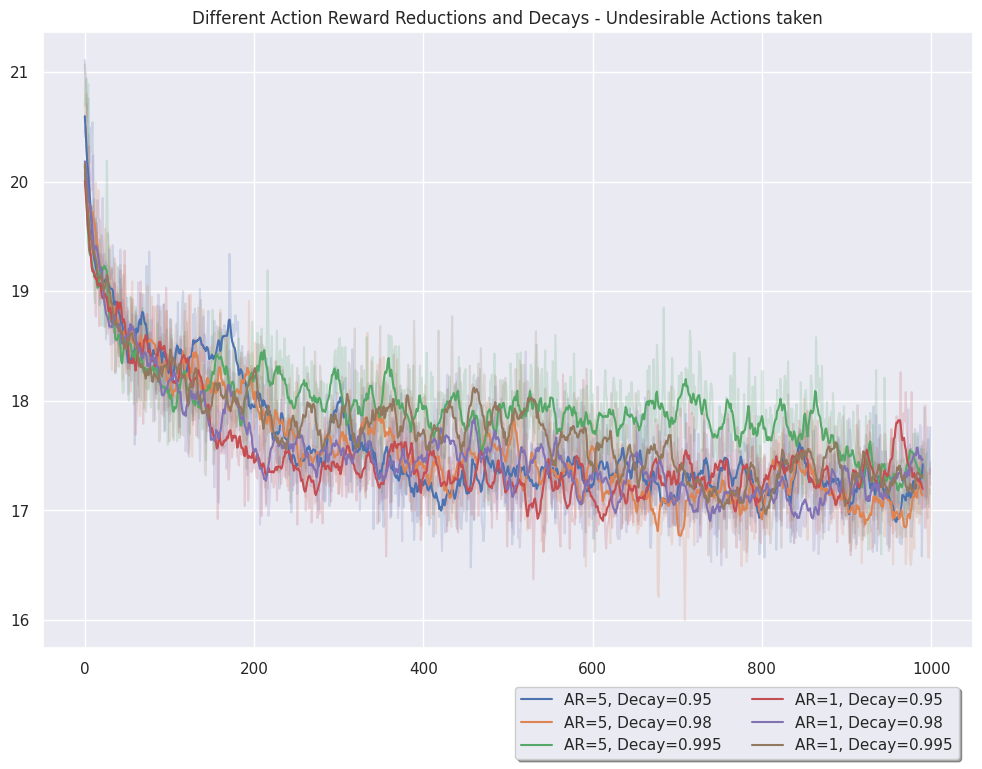

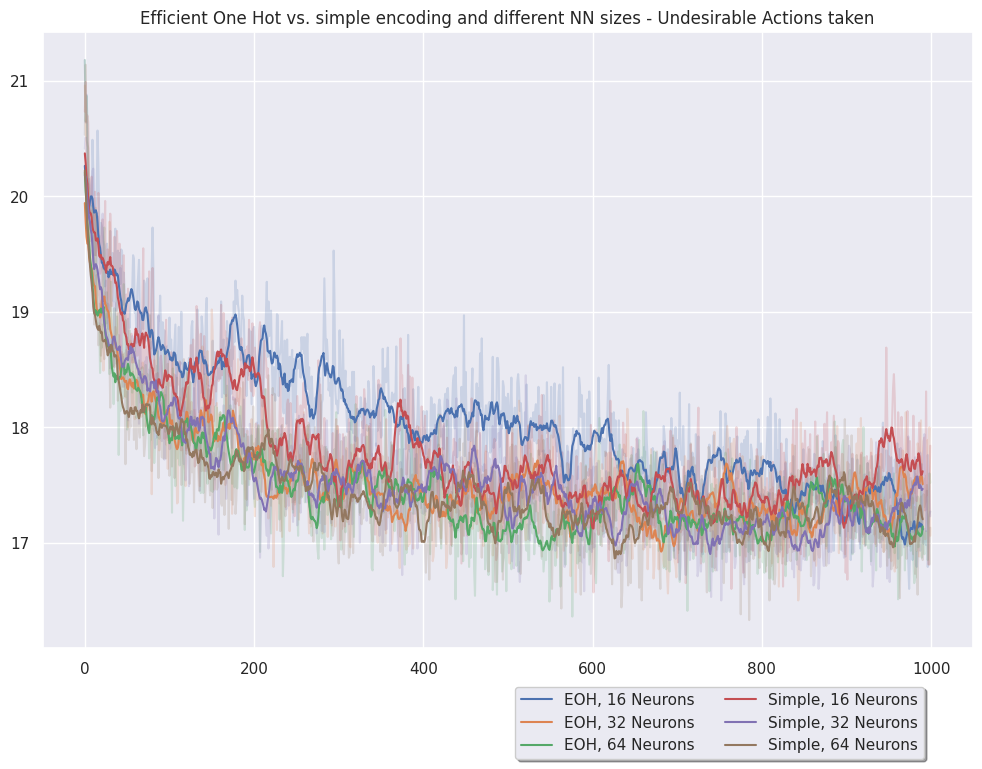

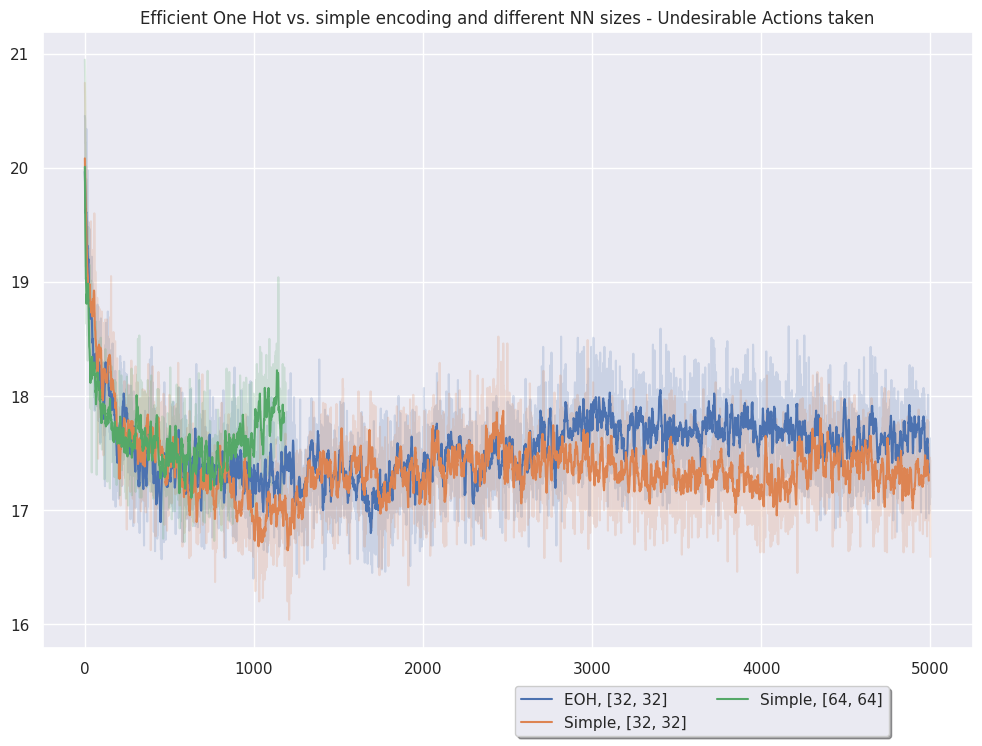

In [70]:
plot_metric(logs_to_evaluate, "undesirable_action_0_mean", "Undesirable Actions taken")